# Arrhythmia detection from single ECG signal using Deep Neural Networks

Cardiac arrhythmias are serious cardiovascular diseases that can lead to severe complications, including stroke and death. Early detection and proactive treatment are crucial to prevent adverse outcomes.

Cardiac arrhythmias are typically diagnosed through electrocardiograms (ECGs). This project aim at training a Convolutional Neural Network (CNN) and a Recurrent Neural Network (RNN) to classify arrhythmias from a single ECG signal, comparing their performance with a Long Short-Term Memory (LSTM) model, found on Kaggle.





# Table of content

- [1. Preliminary operations](#1)
  - [1.1 Useful module import](#1-1)
  - [1.2 Utility functions](#1-2)
  - [1.3 Dataset](#1-3)
- [2. Data Exploratory Analysis](#2)
    - [2.1 Interactive exploration of ECG signals](#2-1)
- [3. Data preprocessing](#3)
- [4. Convolutional Neural Network](#4)
    - [4.1 Model definition](#4-1)
    - [4.1 Hyperparameter tuning](#4-1)
    - [4.2 Model creation and training](#4-2)
    - [4.3 Performance Evaluation](#4-3)
    - [4.4 Error Analysis](#4-4)
- [5. Recurrent Neural Network](#5)
    - [5.1 Model Definition](#5-1)
    - [5.2 Hyperparameter Tuning](#5-2)
    - [5.3 Model Creation and Training](#5-3)
    - [5.4 Performance Evaluation](#5-4)
    - [5.5 Error Analysis](#5-5)
- [6. Comparison Between Models](#6)

<a name='1-1'></a>
### Useful modules import
The following cell imports the modules needed to execute the project.

In [3]:
import os

import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
import seaborn as sns
from seaborn import countplot
sns.set_palette(sns.color_palette('viridis'))

import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras import activations

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight # compute_class_weight returns Array with class_weight_vect[i] the weight for i-th class.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize # label_binarize is used to convert labels to binary form

import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from ipywidgets import interact, IntSlider, fixed

In [33]:
print("Tensorflow version:",tf.__version__) # 2.16.2, the latest is 2.17
print("Keras version:",keras.__version__) # 3.4.0, the latest is
#print("wandb version:",wandb.__version__) # 0.17.5
print("Sklearn version:",sklearn.__version__) # 1.2.2
#print("Python version", Python.__version__)

Tensorflow version: 2.17.1
Keras version: 3.5.0
Sklearn version: 1.5.2


<a name='1-2'></a>
### Utility functions
The following code define some utility functions that will be used in this project.

- **plot_interactive_idx**, plots an ECG signal and its label interactively.
- **plot_history**, plots training and validation loss and an optional metric.
- **show_confusion_matrix**, plots the confusion matrix.
- **class_weights**, calculate class weights to handle imbalance. As reported in the following barplots, the dataset is highly unbalanced, to tackle this problem during the hyperparameter tuning and the final training of the model, the weights for the different classes will be computed in order to implement the weighted loss.


In [36]:
# Interactive exploration, can be used in Jupyter Notebook
def plot_interactive_idx(x, y):
    """
    Plots an ECG signal and its label interactively.

    Parameters
    ----------
    x : numpy array
        Data
    y : numpy array
        Labels
    """
    def plot_ECG(x, y, idx):
        """
        This function plots an ECG signal and its label.
        """
        plt.plot(x[idx])
        plt.title('ECG Signal, label = ' + str(y[idx]))
        plt.ylabel('Amplitude[mV]')
        plt.show()

    # Create a slider to explore the data
    start_idx = IntSlider(min=0, max=len(x)-1, step=1, description='Index')
    interact(plot_ECG, x=fixed(x), y=fixed(y), idx=start_idx)


def plot_history(history,metric=None):
    """
    Plots training and validation loss and an optional metric.

    Parameters
    ----------
    history : keras.callbacks.History
        History object returned by the `fit` method of a Keras model
    metric : str, optional
        Name of the metric to plot
    """
    fig, ax1 = plt.subplots(figsize=(6, 6)) #figsize=(10,8)

    epoch_count=len(history.history['loss'])

    line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
    ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
    ax1.set_xlim([1,epoch_count])
    ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
    ax1.set_ylabel('loss',color = line1.get_color())
    ax1.tick_params(axis='y', labelcolor=line1.get_color())
    ax1.set_xlabel('Epochs')
    _=ax1.legend(loc='lower left')

    if (metric!=None):
        ax2 = ax1.twinx()
        line2,=ax2.plot(range(1,epoch_count+1),history.history[metric],label='train_'+metric)
        ax2.plot(range(1,epoch_count+1),history.history['val_'+metric],label='val_'+metric,color = line2.get_color(), linestyle = '--')
        ax2.set_ylim([0, max(max(history.history[metric]),max(history.history['val_'+metric]))])
        ax2.set_ylabel(metric,color=line2.get_color())
        ax2.tick_params(axis='y', labelcolor=line2.get_color())
        _=ax2.legend(loc='upper right')
    plt.show() #block=False

def show_confusion_matrix(conf_matrix, class_names, figsize=(10,10)):
    """
    Plots the confusion matrix.

    Parameters
    ----------
    conf_matrix : numpy array
        Confusion matrix
    class_names : list
        Class names
    figsize : tuple, optional
        Size of the figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    img = ax.matshow(conf_matrix)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('Real')
    plt.xlabel('Predicted')
    #plt.colorbar()

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, '{0:.1%}'.format(conf_matrix[i, j]),
                           ha='center', va='center', color='w')
    plt.show() #block=False

def class_weights(y_train):
    """
    Calculate class weights to handle imbalance.
    Arg:
    y_train: array, training labels
    Returns:
    class_weights_dict: dictionary, mapping class indices to weights
    """
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y = y_train
    )
    print("Computed class weights:", class_weights) # array of 5 elements, not dictionary
    # class_weights[0]= 0.24, class_weights[1]= ... class_weights[4]= ...

    # Create a dictionary mapping class indices to weights
    class_weights_dict = dict(enumerate(class_weights)) # enumerate returns an iterator with index and value pairs like [(0, 0.24), (1, 0.5), (2, 0.75), (3, 1.0), (4, 1.25)] and then dictionary {0: 0.24, 1: 0.5, 2: 0.75, 3: 1.0, 4: 1.25}
    print("Class weights:", class_weights_dict)
    return class_weights_dict

<a name='1-3'></a>
### Dataset
For this project, the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat), derived from the MIT-BIH Arrhythmia Dataset, was used. The MIT-BIH Arrhythmia Database contains ECG recordings collected by the BIH Arrhythmia Laboratory between 1975 and 1979. The dataset consists of 48 half-hour excerpts of two-channel ambulatory ECG recordings from 47 subjects. It includes 109,446 individual ECG signals, each labeled with one of the following classes:
- 0: "Normal Beats",
- 1: "Supraventricular Ectopy Beats",
- 2: "Ventricular Ectopy Beats",
- 3: "Fusion Beats",
- 4: "Unclassifiable Beats”

The dataset is stored in two CSV files: "mitbih_train.csv" and "mitbih_test.csv".

### Dataset download
The following code loads in memory the Kaggle dataset. In particular, it detects on which environment you are running the code (Google Colab or Kaggle) and conditionally execute code specific to each platform.

In [35]:
# Detect environment
import os

is_colab = 'COLAB_GPU' in os.environ
is_kaggle = 'KAGGLE_URL_BASE' in os.environ

if is_colab:
    print("Running on Google Colab")
    !pip install wandb # on Google Colab
elif is_kaggle:
    print("Running on Kaggle")
    !pip install wandb --upgrade # on Kaggle
else:
    print("Running on another environment")


import wandb
from wandb.integration.keras import WandbMetricsLogger
#print("wandb version:",wandb.__version__) # 0.17.5

# Conditional Code for Google Colab
if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    import shutil

    kaggle_json_path = '/content/drive/MyDrive/kaggle.json'
    os.makedirs('/root/.kaggle', exist_ok=True)
    shutil.copy(kaggle_json_path, '/root/.kaggle/kaggle.json')

    !pip install -q kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d shayanfazeli/heartbeat
    !unzip heartbeat.zip

    path = '/content/'

# Conditional Code for Kaggle
if is_kaggle:
    import warnings
    warnings.filterwarnings("ignore")

    import os
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

    path = '/kaggle/input/heartbeat/'

Running on Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
heartbeat.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  heartbeat.zip
replace mitbih_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: mitbih_test.csv         
replace mitbih_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: mitbih_train.csv        y

replace ptbdb_abnormal.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: ptbdb_abnormal.csv      
replace ptbdb_normal.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace ptbdb_normal.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ptbdb_normal.csv        


The following code load the training and test datasets from csv files. Both datasets do not contain header rows and use a comma as the delimiter. It also displays a concise summary of the training dataset using the `info()` method. Finally, using the `head()` method displays the first 5 rows of the training dataset.

In [37]:
train_df = read_csv(path + 'mitbih_train.csv', delimiter=',', header=None) #87554 rows × 188 columns
test_df = read_csv(path + 'mitbih_test.csv', delimiter=',', header=None) #21892 rows × 188 columns

print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB
None


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The following code defines the names for the different possible classes of the ECG signals.

In [38]:
class_names = ["Normal Beats","Supraventricular Ectopy Beats","Ventricular Ectopy Beats","Fusion Beats","Unclassifiable Beats"]

### Missing values
The following code counts the missing values for each column of the dataframes and also the total number of missing values in the training and test datasets.

In [39]:
# Count missing values for each column
missing_train = train_df.isnull().sum()
missing_test = test_df.isnull().sum()

# Total missing values in the entire DataFrame
total_missing_train = missing_train.sum()
total_missing_test = missing_test.sum()


print("Missing values in training set for each column:")
print(missing_train)

print("\nTotal missing values in training set:")
print(total_missing_train)

print("\nMissing values in test set for each column:")
print(missing_test)

print("\nTotal missing values in test set:")
print(total_missing_test)

Missing values in training set for each column:
0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64

Total missing values in training set:
0

Missing values in test set for each column:
0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64

Total missing values in test set:
0


### Split signals and labels
The following code separate the ECG signals and the labels for the training and test set.

In [40]:
## Separate ECG signals and labels (training and test)
x_train = train_df.iloc[:, :-1].values # Numpy array # (87554, 187)
y_train = train_df.iloc[:, -1].values # Numpy array  # (87554,)

x_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

print("x train shape:",x_train.shape)
print("y train shape:",y_train.shape)
print("x test shape:",x_test.shape)
print("y test shape:",y_test.shape)

class_labels = np.unique(y_train)

x train shape: (87554, 187)
y train shape: (87554,)
x test shape: (21892, 187)
y test shape: (21892,)


<a name='2'></a>
## Exploratory Data Analysis

In this section, we perform an exploratory data analysis to interactively visualize the signals, and understand the distribution of class labels across the training and test datasets.

<a name='2-1'></a>
### Interactive exploration of the ECG signals
The following code allows the interactive visualization of the ECG signals, allows to visualize the different classes that are present on the dataset.

In particular, it defines a function `plot_interactive_idx` that can plot ECG signals interactively using a slider to explore different indices.

In [41]:
def plot_interactive_idx(x, y):
    """
    This function plots an ECG signal and its label interactively.
    Can be used to explore the data (training and test) interactively.
    Can be used in Jupyter Notebook.
    """
    def plot_ECG(x, y, idx):
        """
        This function plots an ECG signal and its label.
        """
        plt.plot(x[idx])
        plt.title('ECG Signal, label = ' + str(y[idx]))
        plt.ylabel('Amplitude[mV]')
        plt.show()

    # Create a slider to explore the data
    start_idx = IntSlider(min=0, max=len(x)-1, step=1, description='Index')
    interact(plot_ECG, x=fixed(x), y=fixed(y), idx=start_idx)

In [42]:
plot_interactive_idx(x_train, y_train)

interactive(children=(IntSlider(value=0, description='Index', max=87553), Output()), _dom_classes=('widget-int…

### Visualization of ECG signals for the different classes
Here, we visualize the ECG signals related to the five different classes.

Class labels: [0. 1. 2. 3. 4.]


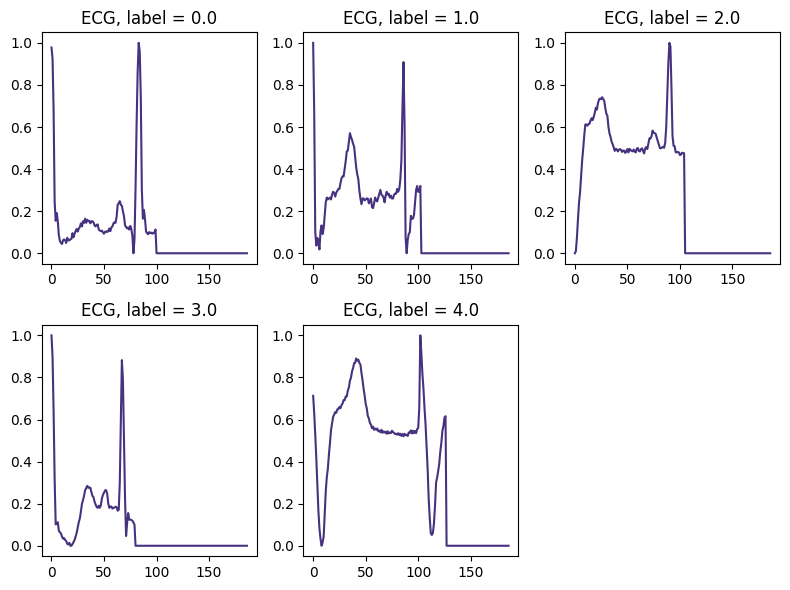

In [43]:
class_labels = np.unique(y_train)
print("Class labels:", class_labels)

plt.figure(figsize=(8, 6))
for i,label in enumerate(class_labels):
    # Get the indices of the first instance of each class
    idx = np.where(y_train == label)[0][0]
    #print(f'Plotting class {int(label)} at index {idx}')
    plt.subplot(2,3,i+1)
    plt.plot(x_train[idx])
    plt.title('ECG, label = ' + str(y_train[idx]))
plt.tight_layout()

<a name='2-1'></a>
### Class distribution

The following code plots the class distribution in the training and test sets, using a barplot.

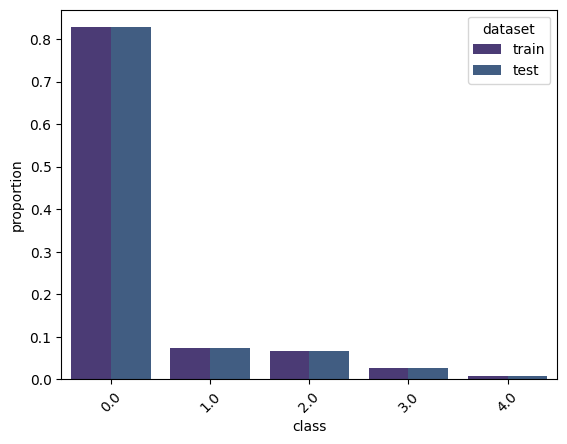

In [44]:
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

count_train = y_train_series.value_counts()
count_test = y_test_series.value_counts()

# Proportions
train_proportions = count_train / count_train.sum()
test_proportions = count_test / count_test.sum()

proportion_df = pd.DataFrame({
    'class': np.unique(y_train),
    'train': train_proportions,
    'test': test_proportions
})

proportion_df_melted = pd.melt(proportion_df, id_vars='class', var_name='dataset', value_name='proportion')

plt.figure()
sns.barplot(x='class',y='proportion',hue='dataset', data=proportion_df_melted)
plt.xticks(rotation=45)
plt.savefig('class_distribution_train_test.png',dpi=300, bbox_inches='tight')
plt.show()

<a name='3'></a>
## Data preprocessing
In this section the preprocessing of the data is performed, which consist of two main steps:
1. Split of the training dataset in also a validation set
2. Normalization, which standardize the features by removing the mean and scaling to unit variance.

<a name='3-'></a>
###  Splitting in training, validation and test sets

The splitting of the training set was performed ensuring the same distribution of the different classes across the different datasets. The validation sets were extracted from the test set, considering its high number of samples.

In [45]:
# random state is set to 42 for reproducibility
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=42, stratify=y_train)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

print("x train shape:",x_train.shape)
print("y train shape:",y_train.shape)
print("x val shape:",x_val.shape)
print("y val shape:",y_val.shape)
print("x test shape:",x_test.shape)
print("y test shape:",y_test.shape)

x train shape: (87554, 187)
y train shape: (87554,)
x val shape: (10946, 187)
y val shape: (10946,)
x test shape: (10946, 187)
y test shape: (10946,)


<a name='3-'></a>
###  Class distribution
The following code plots the normalized class distributions for training, validation, and test datasets. It creates a barplot with separate bars for each dataset, normalized to percentages.

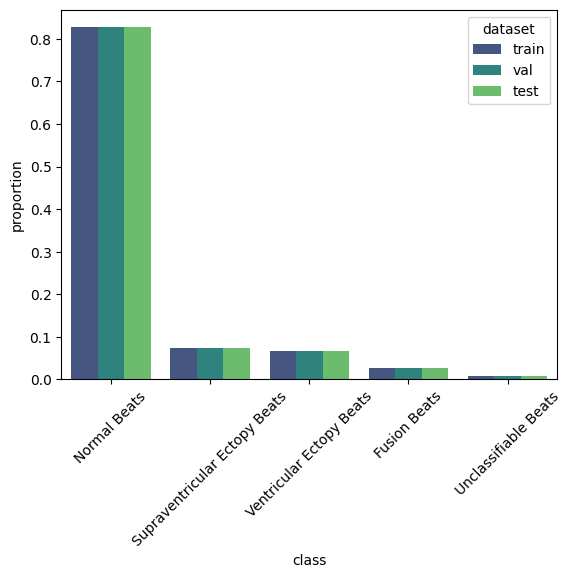

In [46]:
y_train_series = pd.Series(y_train)
y_val_series = pd.Series(y_val)
y_test_series = pd.Series(y_test)

count_train = y_train_series.value_counts()
count_val = y_val_series.value_counts()
count_test = y_test_series.value_counts()

# Proportions
train_proportions = count_train / count_train.sum()
val_proportions = count_val / count_val.sum()
test_proportions = count_test / count_test.sum()

proportion_df = pd.DataFrame({
    'class': class_names,
    'train': train_proportions,
    'val': val_proportions,
    'test': test_proportions
})

proportion_df_melted = pd.melt(proportion_df, id_vars='class', var_name='dataset', value_name='proportion')

plt.figure()
sns.barplot(x='class',y='proportion',hue='dataset', palette='viridis', data=proportion_df_melted)
plt.xticks(rotation=45)
plt.show()

### Normalization
The following code normalizes the ECG signals data using the `StandardScaler`. It ensures that the data has a mean of 0 and a standard deviation of 1. This can improve the performance and convergence speed of the machine learning algorithm.

In [47]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

<a name='4'></a>
## Convolutional Neural Network

In this section, we will explore the implementation of a Convolutional Neural Network (CNN) for our classification task. We will cover the processes of hyperparameter tuning using Sweeps of Weights and Biases (W&B), training the model, and evaluating its performance using relevant metrics, such as precision, recall, and F1 score.

<a name='4-1'></a>
###  Model definition
The `build_CNN` function is designed to create a Convolutional Neural Network (CNN) model using the Keras Functional API.
The CNN model consists of 3 convolutional layers, each of them performing also Batch Normalization, Dropout layers, and ReLU as activation function, followed by a fully connected layer and an output layer having a number of neurons equal to the number of possible classes and with a softmax activation function to obtain as output probabilities for the different classes.

This model definition is motivated by initial quick experiments which showed good initial results.

In [1]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import activations

def build_CNN_last(
    input_shape,
    output_shape,
    layer_1_size,
    layer_2_size,
    layer_3_size,
    number_cnn_layers,
    filters_in_additional_layers,
    layer_FC_size,
    dropout_rate
):
    """
    Builds a CNN model with a variable number of 1D convolutional layers using the Functional API.

    Args:
    input_shape (tuple): Shape of the input data.
    output_shape (int): Number of classes for the output layer.
    layer_1_size (int): Number of filters in the first convolutional layer.
    layer_2_size (int): Number of filters in the second convolutional layer.
    layer_3_size (int): Number of filters in the third convolutional layer.
    number_cnn_layers (int): Total number of convolutional layers.
    filters_in_additional_layers (int): Number of filters in additional convolutional layers beyond the third layer.
    layer_FC_size (int): Number of neurons in the fully connected layer.
    dropout_rate (float): Dropout rate for all dropout layers.

    Returns:
    model (Model): Keras Functional API model.
    """
    input_layer = Input(input_shape)

    # First Convolutional Layer
    x = Conv1D(filters=layer_1_size, kernel_size=3, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = activations.relu(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Second Convolutional Layer
    x = Conv1D(filters=layer_2_size, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = activations.relu(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Third Convolutional Layer
    x = Conv1D(filters=layer_3_size, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = activations.relu(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Additional Convolutional Layers
    for i in range(number_cnn_layers - 3):
        x = Conv1D(filters=filters_in_additional_layers, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
        x = activations.relu(x)
        #x = MaxPooling1D(pool_size=2)(x)  # Uncomment if you want to include additional pooling layers

    # Flatten and Dense layers
    x = Flatten()(x)
    x = Dense(layer_FC_size, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    # Output Layer
    output_layer = Dense(output_shape, activation='softmax')(x)

    # Creating the model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

<a name='4-1'></a>
### Hyperparameter tuning using sweep weights and biases
For the hyperparameter tuning sweeps of [weights and biases](https://wandb.ai/) was used.

The following code was used to find the best hyperparameters for the CNN model previously defined.

<a name='4-1'></a>
#### Hyperparameter Optimization Configuration

To initialize a hyperparameter sweep using the Weights and Biases (W&B) library, we have to first define the sweep configuration. The sweep configuration specifies the parameters to tune and their respective ranges or distributions.


This project uses a hyperparameter optimization setup with the following parameters:

1. **Optimization Method**:
   - **Bayesian Optimization**: This method is used to find the best hyperparameters by modeling and exploring the hyperparameter space efficiently.

2. **Metric to Optimize**:
   - **Goal**: Minimize the `val_loss` metric during training. This means we aim to reduce the validation loss to improve model performance.

3. **Hyperparameter Space**:
   - **Layer Sizes**:
     - `layer_1_size`: [64, 128, 256, 512]
     - `layer_2_size`: [64, 128, 256, 512]
     - `layer_3_size`: [64, 128, 256, 512]
     - `layer_FC_size`: [64, 128, 256, 512]
   - **Number of Convolutional Layers**:
     - `number_cnn_layers`: [4, 5, 6, 7, 8]
   - **Filters in Additional Layers**:
     - `filters_in_additional_layers`: [16, 32, 64, 128]
   - **Dropout Rate**: [0, 0.1, 0.25, 0.5]
   - **Learning Rate**: Selected from a logarithmic scale between  $10^{-4}$ and $10^{-2}$ for effective learning..
   - **Epochs**: Fixed at 15 for training iterations.

4. **Early Terminate**:
   - **Hyperband**: This technique is used to terminate underperforming trials early, optimizing computational resources and speeding up the search process.

This configuration is designed to efficiently explore the hyperparameter space.


In [17]:
cnn_sweep_config = {
    'method': 'bayes',  # Choose from 'random', 'grid', or 'bayes'
    'name': 'cnn_sweep_final_final_split2',  # Name to track different sweeps for CNN models
    'metric': {
        'goal': 'minimize',
        'name': 'val_loss'
    },
    'parameters': {
        'layer_1_size': {
            'values': [64, 128, 256, 512]
        },
        'layer_2_size': {
            'values': [64, 128, 256, 512]
        },
        'layer_3_size': {
            'values': [64, 128, 256, 512]
        },
        'layer_FC_size': {
            'values': [64, 128, 256, 512]
        },
        'number_cnn_layers':{
            'values': [4,5,6,7,8]
        },
        'filters_in_additional_layers':{
            'values':[16,32,64,128]
        },
        'dropout_rate': {
            'values': [0, 0.1, 0.25, 0.5]
        },
        'learning_rate': {
            'distribution': 'log_uniform_values',
            'min': 1e-5,
            'max': 1e-3
        },
        'epochs': {
            'value': 45
        }
    },
    'early_terminate': {
        'type': 'hyperband',  # Enables Hyperband for early termination of unpromising configurations
        'min_iter': 5,  # Minimum number of iterations before early stopping can be applied
    }
}


#### Initialization of the sweep
The following code initialize the sweep with the predefined configuration and it defines the number of iterations for the hyperpameter tuning.

The following line of code is used to initialize a new sweep with the predefined configuration cnn_sweep_config.
```python
sweep_id = wandb.sweep(cnn_sweep_config, project='single_ECG-classification')
```

Instead, this line of code is used to run the sweep with an existing sweep ID, it also specifies the number of iterations for the hyperparameter tuning.
```python
sweep_id, count = 't9jy07ye', 10
```

In [18]:
wandb.login()

# Initialize the sweep with the configuration
#sweep_id = wandb.sweep(cnn_sweep_config, project='single_ECG-classification')

sweep_id = 'v4itddf5' # cnn_sweep_final_final_split2

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#### Computation of class weights
Class weights are computed based on the distribution of the labels in the training data. This helps in dealing with class imbalance by assigning higher weights to less frequent classes.

In [19]:
# Computation of the weights for the different classes, to implement the weighted loss
class_weights_dict = class_weights(y_train)

Computed class weights: [ 0.24162493  7.87710301  3.02536282 27.31794072  2.72287358]
Class weights: {0: 0.24162492583240192, 1: 7.877103013945119, 2: 3.0253628196268143, 3: 27.317940717628705, 4: 2.7228735810915876}


This code cell defines a custom metrics logger.


In [20]:
# # Custom WandbMetricsLogger (Idk if it is necessary, if it is useful or not)
class WandbMetricsLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs)

The following code defines  the  `train` function which initializes a W&B run.

For the training the Adam optimizer was chosen, an early stopping with patience of 8, and a LR scheduling.

In [21]:
def train():
    wandb.init()  # Initializes a new W&B run
    config = wandb.config

    # Define input and output shapes
    input_shape = (x_train.shape[1], 1)  # (187, 1)
    output_shape = len(np.unique(y_train))

    # Build the model with specified configurations
    model = build_CNN_last(
        input_shape=input_shape,
        output_shape=output_shape,
        layer_1_size=config.layer_1_size,
        layer_2_size=config.layer_2_size,
        layer_3_size=config.layer_3_size,
        layer_FC_size=config.layer_FC_size,
        number_cnn_layers=config.number_cnn_layers,
        filters_in_additional_layers=config.filters_in_additional_layers,
        dropout_rate=config.dropout_rate
    )

    # Compile the model with Adam optimizer and sparse categorical crossentropy loss
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',  # When the labels are integers
        metrics=['accuracy']
    )
    # Reduce learning rate when a metric has stopped improving.
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.4,
                                  verbose=1,
                                  patience=2,
                                  min_lr=1e-7)

    # Early stopping callback
    patience = 8
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )

    batch_size = 128

    # Train the model
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        epochs=config.epochs,
        callbacks=[early_stopping, WandbMetricsLogger(), reduce_lr],
        class_weight=class_weights_dict
    )

    # Finish the W&B run
    wandb.finish()

#### Execute the Sweep Agent
The sweep agent is executed to perform hyperparameter tuning using W&B sweeps.

In [22]:
# Execute the sweep agent in the notebook
count = 1  # Specify the number of runs
wandb.agent(sweep_id, project="single_ECG-classification", function=train, count=count) # if I want to add the runs, in one file, I can specify

wandb: Agent Starting Run: l5ywb51t with config:
wandb: 	dropout_rate: 0
wandb: 	epochs: 45
wandb: 	filters_in_additional_layers: 16
wandb: 	layer_1_size: 128
wandb: 	layer_2_size: 64
wandb: 	layer_3_size: 512
wandb: 	layer_FC_size: 512
wandb: 	learning_rate: 4.673419612121673e-05
wandb: 	number_cnn_layers: 6
wandb: Currently logged in as: alessio-guarachi (neuroeng). Use `wandb login --relogin` to force relogin


Epoch 1/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6048 - loss: 0.8599 - val_accuracy: 0.8635 - val_loss: 0.4809
Epoch 2/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8629 - loss: 0.3270 - val_accuracy: 0.8557 - val_loss: 0.4344
Epoch 3/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8833 - loss: 0.2547 - val_accuracy: 0.8820 - val_loss: 0.3520
Epoch 4/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9060 - loss: 0.1973 - val_accuracy: 0.9105 - val_loss: 0.2728
Epoch 5/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9088 - loss: 0.2022 - val_accuracy: 0.9139 - val_loss: 0.2564
Epoch 6/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9291 - loss: 0.1463 - val_accuracy: 0.9185 - val_loss: 0.2446
Epoch 7/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9245 - loss: 0.1367 - val_accuracy: 0.9208 - val_loss: 0.2414
Epoch 8/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9406 - loss: 0.1162 - val_accuracy

accuracy,▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇█████████████
loss,█▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▄▄▅▅▇▇▄▆▅▇▅▆▇▇█▇▆███▇█▇▇█
val_loss,█▇▆▄▄▄▄▂▂▄▂▃▂▃▂▁▂▁▂▃▁▁▁▂▁▂▂▁
accuracy,0.97665
loss,0.03658
val_accuracy,0.96757
val_loss,0.11767


### Results of the hyperparameter tuning.

**Parallel Coordinates Plot**

At the beginning I only performed the hyperparameter tuning using a fixed number of convolutional blocks, equal to 3. Then seeing the obtained parallel coordinate plot, seeing that some hyperparameters reached one of the two extremes of the interval I decided to enlarge the range of values and also increase the layers of the model.

![](https://github.com/Alessio1599/single-ECG-classification/blob/main/results/cnn/W&B%20Chart%2008_12_2024,%2023_15_24.png?raw=true)

Below you can see the result of the sweep defined earlier.
![](https://github.com/Alessio1599/single-ECG-classification/blob/main/results/cnn/W&B%20Chart_cnn_sweep_final_final_split2.png?raw=true)


Analyzing the obtained plot, I've obtained the best hyperparameters that I used for the training of the final model.

In the figure you can see the last hyperparemeter session that I've performed, before it I restricted the range of the number of filter in the first layer from [64-512] to [32,128].

<a name='4-2'></a>
### Model creation

The following code train the CNN model using the best hyperparameters identified from the results obtained from the hyperparameter tuning.

For the final training, train and the validation sets are combined, and the class weights are recomputed.

Considering the "cnn_sweep_final_final_split2" I

In [54]:
# Define the best hyperparameters manually
best_hyperparameters = {
    'layer_1_size': 64,
    'layer_2_size': 128,
    'layer_3_size': 256,
    'layer_FC_size': 512,
    'number_cnn_layers': 6,
    'filters_in_additional_layers': 64,
    'dropout_rate': 0,
    'learning_rate': 2e-4,
}

# Compute class weights
class_weights_dict = class_weights(y_train)

# Define the input and output shapes
input_shape = (x_train.shape[1], 1)  # Example: (187, 1)
output_shape = len(np.unique(y_train))  # Number of unique classes

# Build the model using the best hyperparameters
model = build_CNN_last(
    input_shape=input_shape,
    output_shape=output_shape,
    layer_1_size=best_hyperparameters['layer_1_size'],
    layer_2_size=best_hyperparameters['layer_2_size'],
    layer_3_size=best_hyperparameters['layer_3_size'],
    layer_FC_size=best_hyperparameters['layer_FC_size'],
    number_cnn_layers=best_hyperparameters['number_cnn_layers'],
    filters_in_additional_layers=best_hyperparameters['filters_in_additional_layers'],
    dropout_rate=best_hyperparameters['dropout_rate']
)

model.summary()

Computed class weights: [ 0.24162493  7.87710301  3.02536282 27.31794072  2.72287358]
Class weights: {0: 0.24162492583240192, 1: 7.877103013945119, 2: 3.0253628196268143, 3: 27.317940717628705, 4: 2.7228735810915876}


<a name='4-2'></a>
### Final Model training

In the following code the final model is trained using the best hyperparameters.

In [55]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=best_hyperparameters['learning_rate'])
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.4,
                              verbose=1,
                              patience=2,
                              min_lr=1e-7)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'cnn_model_exam.keras',
    monitor='val_accuracy',
    save_best_only=True
)


epochs = 45
batch_size = 128

# Train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, checkpoint, reduce_lr],
    class_weight=class_weights_dict
)

Epoch 1/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.7579 - loss: 0.5351 - val_accuracy: 0.8217 - val_loss: 0.5182 - learning_rate: 2.0000e-04
Epoch 2/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8903 - loss: 0.2208 - val_accuracy: 0.9145 - val_loss: 0.2339 - learning_rate: 2.0000e-04
Epoch 3/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9158 - loss: 0.1680 - val_accuracy: 0.8841 - val_loss: 0.3098 - learning_rate: 2.0000e-04
Epoch 4/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9270 - loss: 0.1287 - val_accuracy: 0.9313 - val_loss: 0.2199 - learning_rate: 2.0000e-04
Epoch 5/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9424 - loss: 0.1094 - val_accuracy: 0.9427 - val_loss: 0.1688 - learning_rate: 2.0000e-04
Epoch 6/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9445 - loss: 0.0965 - val_accuracy: 0.9511 - val_loss: 0.1600 - learning_rate: 2.0000e-04
Epoch 7/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accura

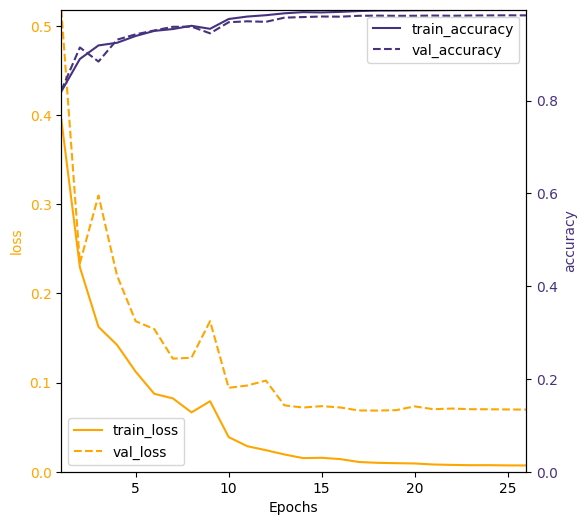

In [56]:
plot_history(history, 'accuracy')

# Load the best model weights
#model.load_weights('best_model.keras')

<a name='4-3'></a>
### Performance Evaluation

The performance of the model is evaluated using several key metrics:
- Confusion matrix
- Precision
- Recall
- F1 score


The computed metrics and the classification report give us a clear understanding of the model's performance across different classes, highlighting areas of strength and potential improvement.


In [57]:
# Evaluation of the model
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score
)
from sklearn.metrics import classification_report

In [58]:
# Predicted probabilities and classes
y_test_proba = model.predict(x_test) # Predicted probabilities
y_test_pred = np.argsort(y_test_proba,axis=1)[:,-1] # Predicted classes, the one with the highest probability

343/343 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


#### Confusion matrix
The following code compute and displays the confusion matrix.

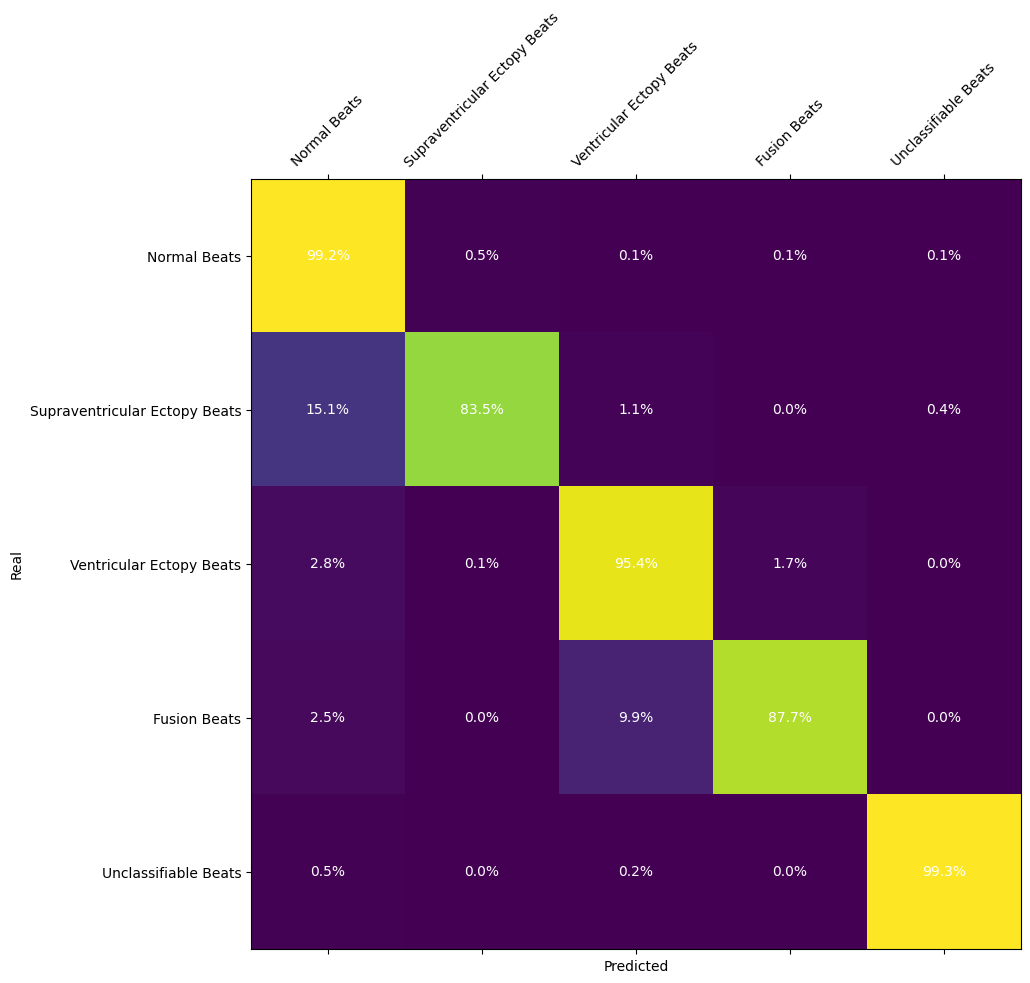

In [59]:
conf_matrix = confusion_matrix(y_test, y_test_pred, normalize='true')
show_confusion_matrix(conf_matrix, class_names)

From the previous figure we can notice that the trained model has difficulties in classifying the "Supraventricular Ectopy Beats" and the "Fusion Beats" classes. In particular 15.9% of signals of the "Supraventricular Ectopy Beats" class are misclassified as "Normal". Instead the "Fusion Beats" class is misclassified as "Ventricular Ectopy Beats" class. In the other 3 classes the model perform good, recognizing at least 95% of the signals.

#### Classification report
This section computes, and displays in the form of a heatmap the classification report, allowing for a graphical view of the precision, recall, and F1-score values.

Text(0.5, 1.0, 'Classification Report')

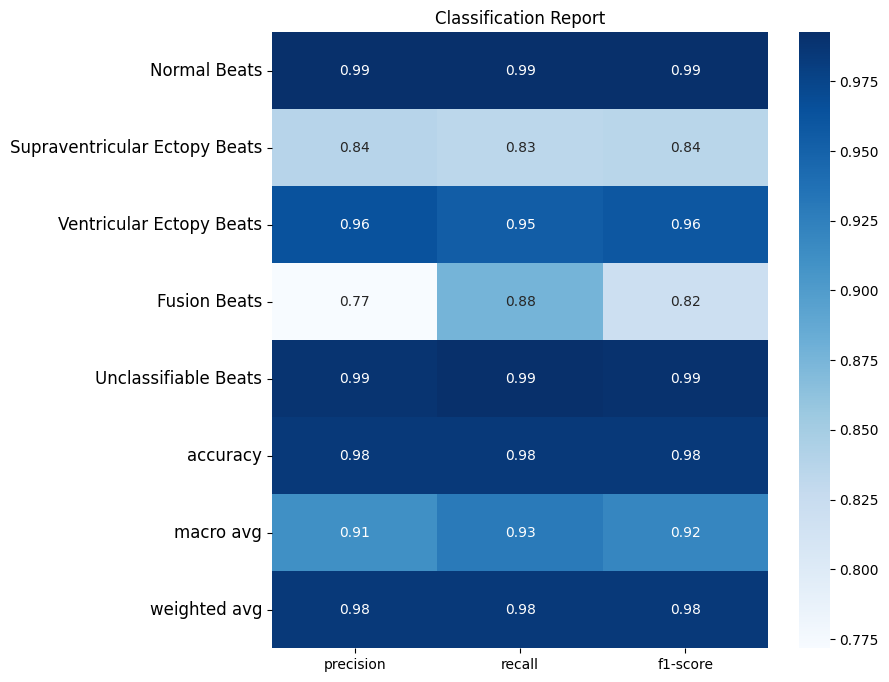

In [60]:
cnn_report = classification_report(
    y_test,
    y_test_pred,
    labels=[0,1,2,3,4],
    target_names=['Normal Beats',"Supraventricular Ectopy Beats","Ventricular Ectopy Beats","Fusion Beats","Unclassifiable Beats"],
    output_dict=True)


# Convert classification report to DataFrame
cnn_report_df = pd.DataFrame(cnn_report).iloc[:-1, :].T # .iloc[:-1, :] to exclude support

# Plotting the classification report
plt.figure(figsize=(8,8))
ax = sns.heatmap(cnn_report_df, annot=True, cmap='Blues')
ax.set_yticklabels(ax.get_yticklabels(),fontsize=12, rotation=0)
plt.title("Classification Report")

From the report it is possible to notice that the model has the lowest precision for the "Fusion Beats" class, this means that for that class there is a relative high number of False Positives. Instead the "Supraventricular Ectopy" class has the lowest recall, this means that for the considered class there is a relative high number of False Negatives.

#### Average signals
The following code computed the mean and the standard deviation (SD) across the different types of signal. Mean and SD are displayed in different subplots for each class of signal. This will be used for the error analysis.

Shape of class_avg_array: (5, 187)


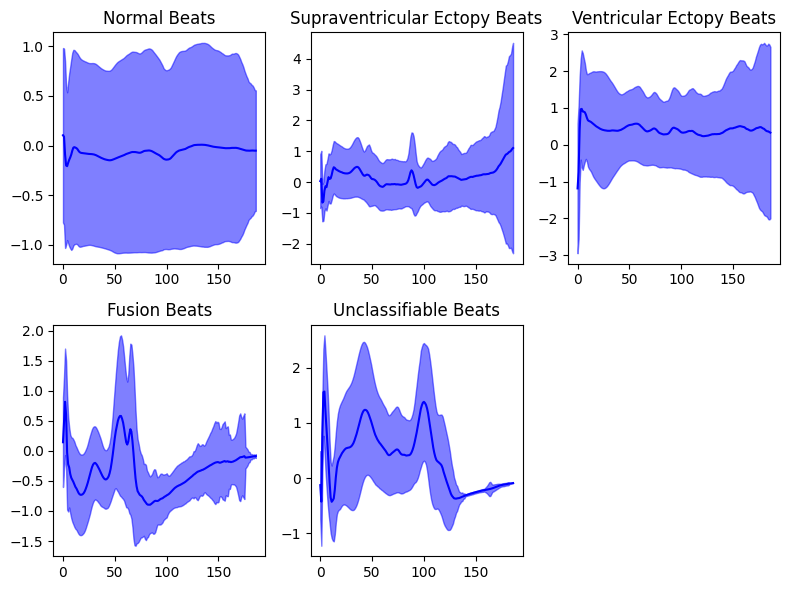

In [62]:
# Average across classes
df =pd.DataFrame(x_train)
df['label'] = y_train

class_avg = df.groupby('label').mean()
class_std = df.groupby('label').std()

class_avg_array = class_avg.to_numpy()
class_std_array = class_std.to_numpy()

print('Shape of class_avg_array:',class_avg_array.shape)

avg_signals = []

plt.figure(figsize=(8,6))
for i in range(class_avg_array.shape[0]):
    plt.subplot(2,3,i+1)
    x = range(class_avg_array.shape[1])
    y = class_avg_array[i, :]
    yerr = class_std_array[i, :]

    plt.fill_between(x, y - yerr, y + yerr, color='blue', alpha=0.5, label='Mean ± STD')
    plt.plot(x, y, color='blue', label='Mean Signal')
    plt.title(class_names[i])

plt.tight_layout()
plt.show()


From the obtained figure it is possible to notice that only for the "Fusion Beats" and "Unclassifiable Beats" it is possible to recognize a pattern, instead for the other classes the mean is almost flat.

<a name='4-4'></a>
### Error Analysis
The following code visualizes twelve random misclassified signals from the test set and shows the true and predicted class probabilities for each signal. The obtained figure can allow a better understanding of the limitations of the model. The title above each signal plot indicates the true label. The text on the right of each plot shows the predicted probabilities for the top classes.

Overlapped to the miscalssified signal I decided to plot also the average signal prediction. In order to check for similarities between those signals.

Future work will consider also the contribution of cardiologists, to better analyze the mistakes of the model

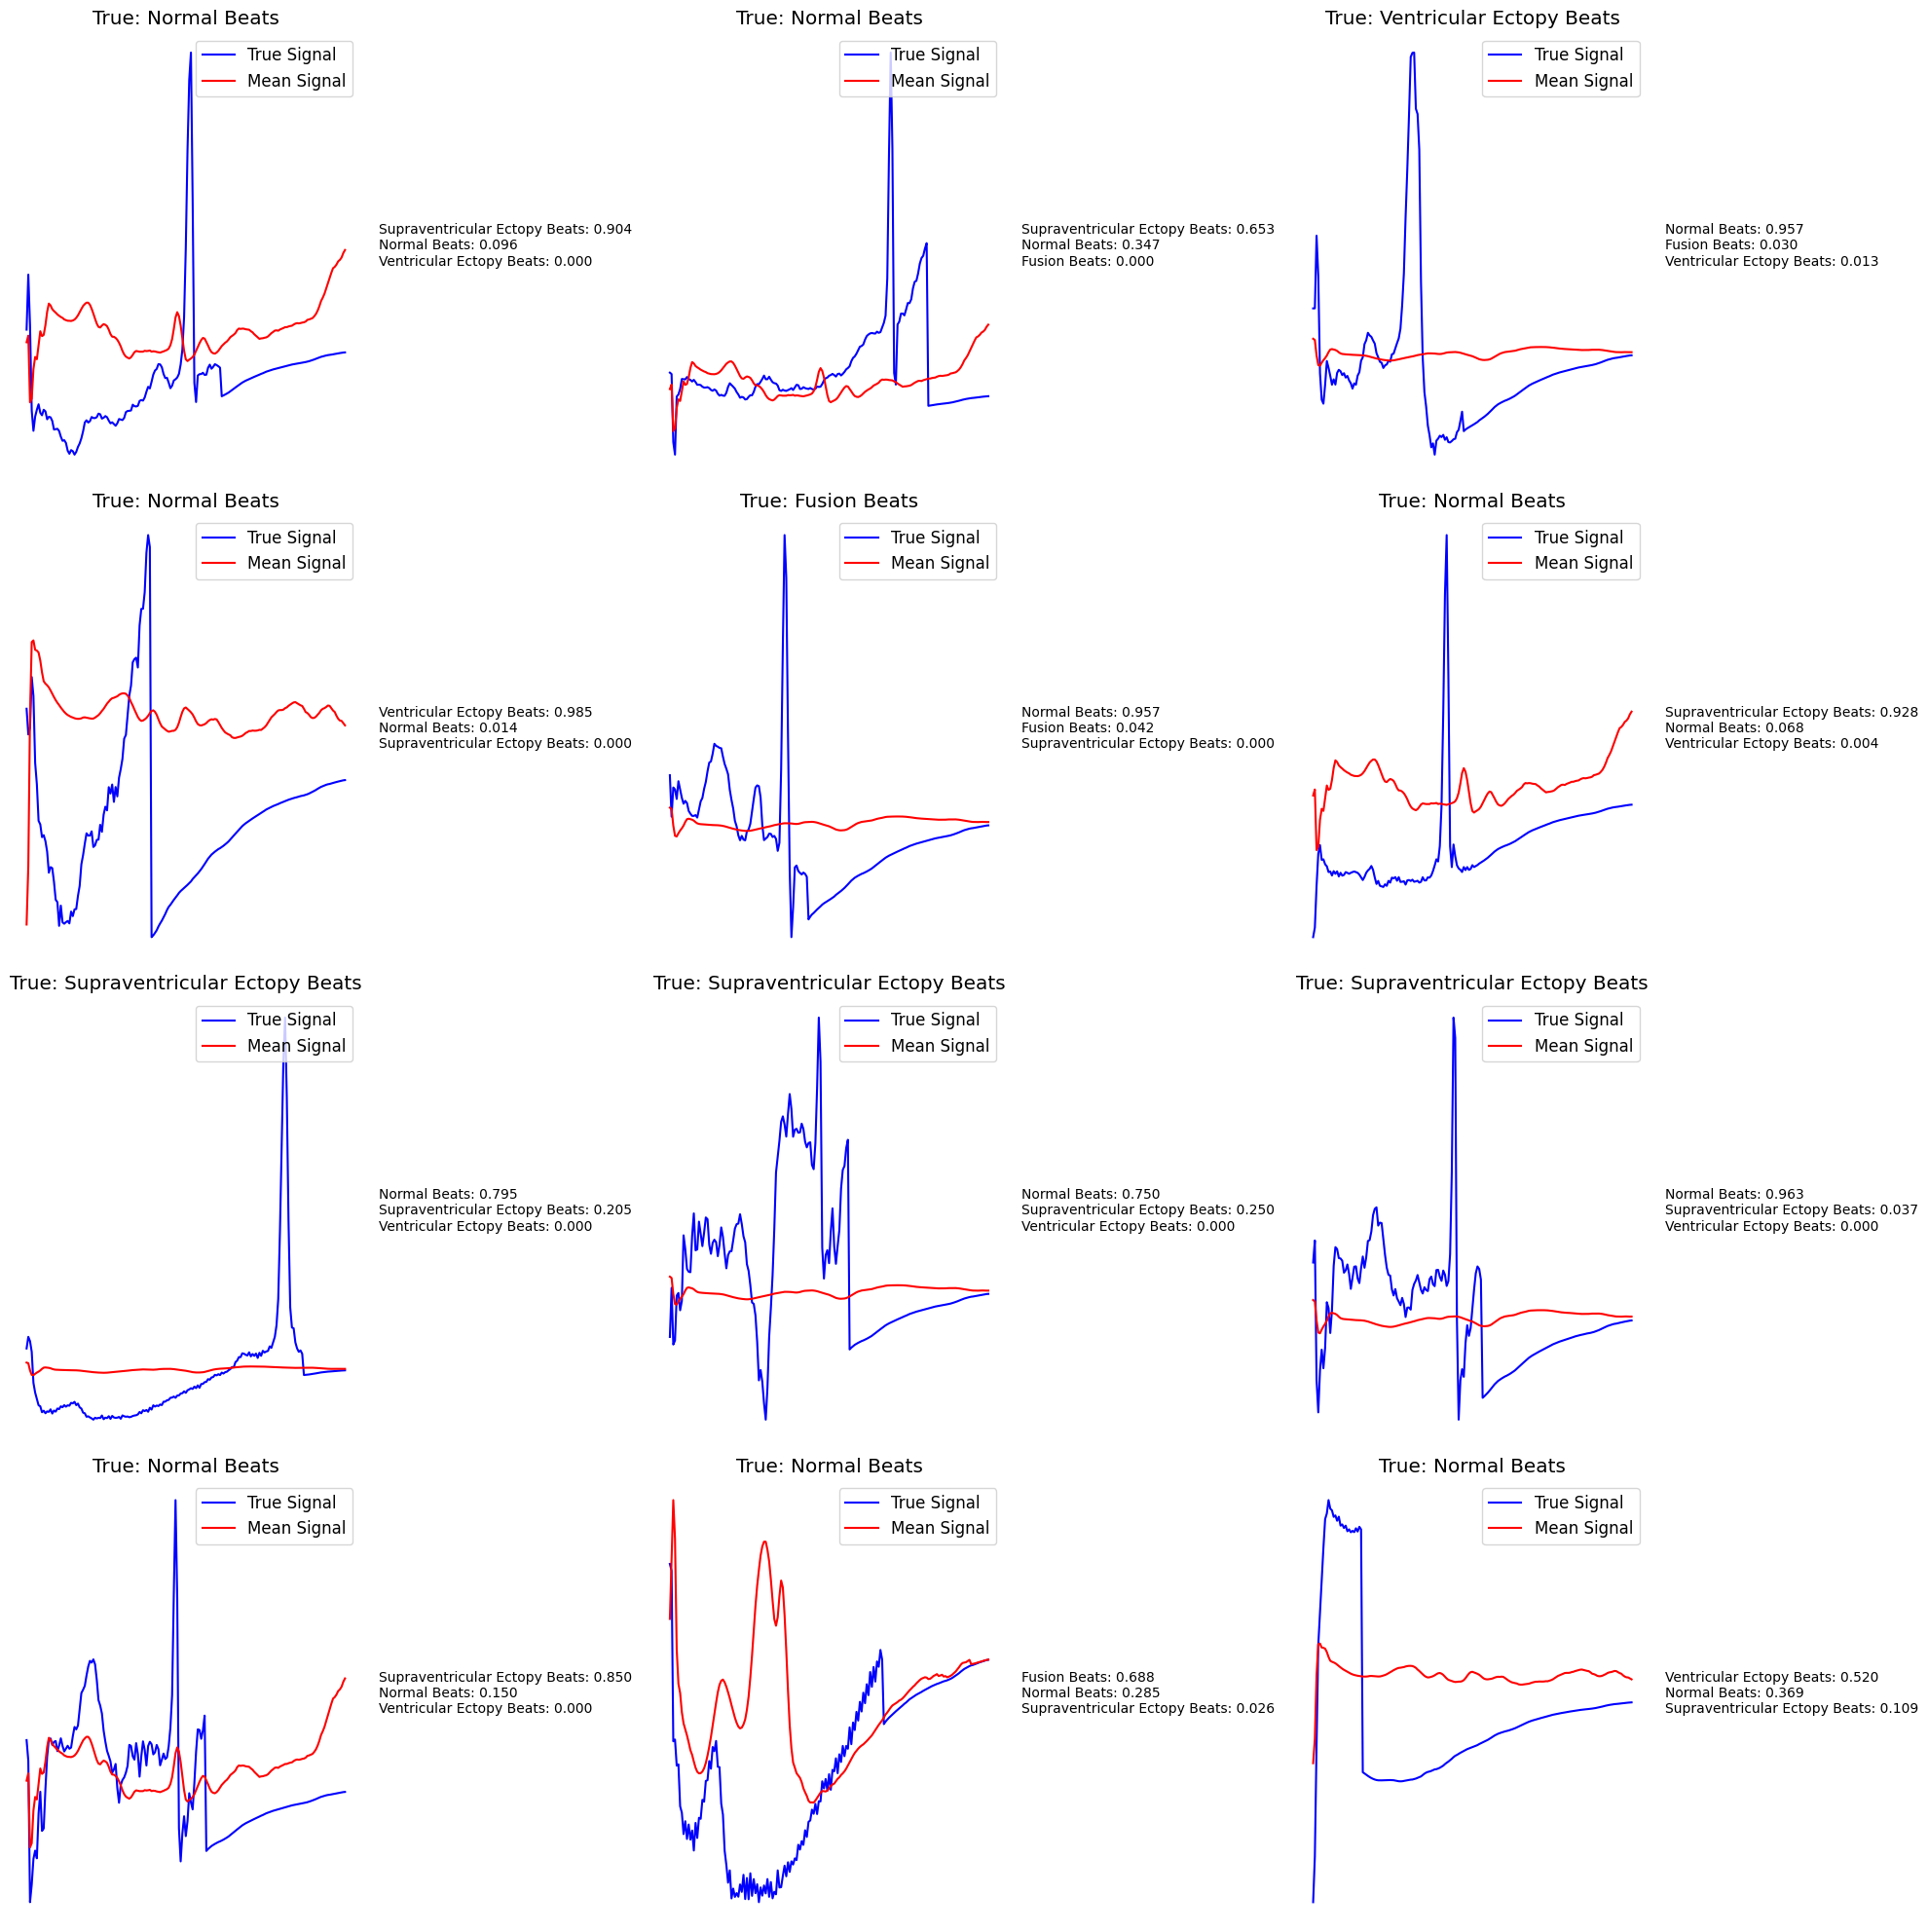

In [63]:
import math

correct = np.equal(y_test, y_test_pred)

signals_to_show = 12 # Number of signals to show

error_indices = np.where(correct == False)[0] # Indices of misclassified signals

if error_indices.shape[0]>0: # Proceed if there are misclassified signals
    signals_per_row = 3 # Number of signals to show per row
    top_class_count = 3 # Top class probabilities to show

    # Randomly select misclassified signals
    selected_indices = []
    for i in range (min(signals_to_show, error_indices.shape[0])):
        random_idx = np.random.randint(0, error_indices.shape[0]-1)
        selected_indices.append(random_idx)
    error_indices = error_indices[selected_indices]

    row_count = math.ceil(len(error_indices) / signals_per_row) # Number of rows
    column_count = signals_per_row # Number of columns
    plt.rcParams.update({'font.size': 12})  # Set font size for the plot

    _, axs = plt.subplots(row_count, column_count, figsize=(20, 5*row_count), squeeze=False)
    # Turn off all axes initially
    for i in range(row_count):
        for j in range(column_count):
            axs[i, j].axis('off')

    # Loop through the selected misclassified signals
    for i in range(len(error_indices)):
        q = i // signals_per_row  # Row index
        r = i % signals_per_row  # Column index
        idx = error_indices[i]  # Current misclassified signal index

        axs[q, r].plot(x_test[idx,:], color='blue', label='True Signal')  # Plot the signal as a line plot
        axs[q, r].set_title(f"True: {class_names[int(y_test[idx])]}")  # Show the true label

        # Find and display the top class probabilities
        sorted_conf_indices = np.argsort(y_test_proba[idx])  # Sort predicted probabilities
        best_indices = sorted_conf_indices[-top_class_count:]  # Get indices of top predicted classes

        text = ''  # Initialize text for displaying top predictions
        for j in range(len(best_indices) - 1, -1, -1):  # Iterate over top predicted classes
            text += '{}: {:.3f}\n'.format(class_names[best_indices[j]], y_test_proba[idx][best_indices[j]])

        # Display the predicted class probabilities next to the plot
        axs[q, r].text(1.05, 0.5, text, horizontalalignment='left', verticalalignment='center',
                       transform=axs[q, r].transAxes, fontsize=10)

        axs[q,r].plot(class_avg_array[best_indices[-1], :], color='red', label='Mean Signal')

        axs[q, r].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

<a name='5'></a>
## Recurrent Neural Network
In this section, we will explore the implementation of a Recurrent Neural Network (RNN) for our classification task. We will cover the processes of hyperparameter tuning using Sweeps of Weights and Biases (W&B), training the model, and evaluating its performance using relevant metrics, such as precision, recall, and F1 score.

For the lack of computational resources (GPU) I wasn't able to perform too many runs on the RNN model but I defined the workflow to perform it.

(I've spent both my resources in Kaggle and Google Colab)



In [64]:
# Reshape the data
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

print(x_train.shape, x_val.shape, x_test.shape)

(87554, 187, 1) (10946, 187, 1) (10946, 187, 1)


<a name='5-1'></a>
###  Model definition
The `build_CNN` function is designed to create a Convolutional Neural Network (CNN) model using the Keras Functional API. The function allows flexibility in selecting the type of RNN layer (LSTM or GRU) and specifies the number of units, layers, and other parameters to construct the model.

In [68]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model


def build_RNN(input_shape,
                output_shape,
                num_units,
                num_layers,
                fc_layer_size,
                dropout_rate):
    input_layer = Input(input_shape)

    x = LSTM(num_units, return_sequences=True)(input_layer)

    for i in range(num_layers - 2):
        x = LSTM(num_units, return_sequences=True)(x)
        x = Dropout(dropout_rate)(x)

    x = LSTM(num_units)(x)

    x = Dense(fc_layer_size, activation='relu')(x)

    output_layer = Dense(output_shape, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

<a name='4-1'></a>
### Hyperparameter tuning using Sweep Weights and Biases
For hyperparameter tuning, sweeps of [Weights and Biases (W&B)](https://wandb.ai/) was used. W&B is a tool designed for tracking experiments, optimizing models, and collaborating with others.

The following code was used to find the best hyperparameters for the RNN model previously defined.

<a name='4-1'></a>
#### Hyperparameter Optimization Configuration
Below is the configuration for a sweep designed to optimize an RNN model's performance.

##### Hyperparameters

- **num_units**: Number of units in RNN layers  
  Values: `[16, 32, 64, 128, 256]`

- **num_layers**: Number of RNN layers  
  Values: `[3, 5, 7]`

- **fc_layer_size**: Size of the fully connected layer  
  Values: `[64, 128, 256, 512]`

- **dropout_rate**: Dropout rate  
  Values: `[0, 0.1, 0.25, 0.5]`

- **learning_rate**: Log-uniform distribution between `1e-5 to 1e-2`

- **epochs**: Fixed at 45  




In [27]:
import wandb

rnn_sweep_config = {
    'method': 'bayes',
    'name': 'rnn_sweep_final_exam_split2_noreducelr',
    'metric': {
        'goal': 'minimize',
        'name': 'val_loss'
    },
    'parameters': {
        'num_units': {
            'values': [16, 32, 64, 128, 256]
        },
        'num_layers': {
            'values': [3, 5, 7] # 9
        },
        'fc_layer_size': {  
            'values': [64, 128, 256, 512]
        },
        'dropout_rate': {
            'values': [0, 0.1, 0.25, 0.5]
        },
        'learning_rate': {
            'distribution': 'log_uniform_values',
            'min': 1e-5,
            'max': 1e-2
        },
        'epochs': {
            'value': 45  # The total number of epochs for each run
        }
    },
    'early_terminate': {
        'type': 'hyperband',  # Enables Hyperband for early termination of unpromising configurations
        'min_iter': 5,  # Minimum number of iterations before early stopping can be applied
    }
}


#### Initialization of the sweep
The following code initialize the sweep with the predefined configuration.

In [28]:
wandb.login() # # Login to Weights and Biases

# Initialize the sweep with the configuration
#rnn_sweep_id = wandb.sweep(rnn_sweep_config, project='single_ECG-classification')
# rnn_sweep_id = '48e5w3gq' # rnn_sweep_final_exam
#rnn_sweep_id = 't22794r9' # rnn_sweep_final_exam_split2
# rnn_sweep_id ='tm962a54' # rnn_sweep_final_exam_split2_batchnorm
rnn_sweep_id = 'dv5r333j' # rnn_sweep_final_exam_split2_noreducelr

#### Computation of the class weights
Class weights are computed based on the distribution of the labels in the training data. This helps in dealing with class imbalance by assigning higher weights to less frequent classes.

In [66]:
# Computation of the weights for the different classes, to implement the weighted loss
class_weights_dict = class_weights(y_train)

# Custom WandbMetricsLogger
class WandbMetricsLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs)

batch_size = 128

Computed class weights: [ 0.24162493  7.87710301  3.02536282 27.31794072  2.72287358]
Class weights: {0: 0.24162492583240192, 1: 7.877103013945119, 2: 3.0253628196268143, 3: 27.317940717628705, 4: 2.7228735810915876}


The following code defines  the  `train` function which initializes a W&B run.

For the training the Adam optimizer was chosen, batch_size of 128, and an early stopping with patience of 8.

In [30]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model

def train():
    wandb.init()
    config = wandb.config

    input_shape = (x_train.shape[1], 1)  # Example input shape
    output_shape = len(np.unique(y_train))  # Output shape based on unique labels

    model = build_RNN(
        input_shape,
        output_shape,
        num_units=config.num_units,
        num_layers=config.num_layers,
        fc_layer_size=config.fc_layer_size,
        dropout_rate=config.dropout_rate
    )

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )


    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.2,
                                  verbose=1,
                                  patience=3,
                                  min_lr=1e-7)


    patience = 8
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        epochs=config.epochs,
        callbacks=[early_stopping, WandbMetricsLogger(), reduce_lr],
        class_weight=class_weights_dict
    )

    # Finish the W&B run
    wandb.finish()

#### Execute the Sweep Agent
The sweep agent is executed to perform hyperparameter tuning using W&B sweeps.

In [31]:
count = 1  # Specify the number of runs
wandb.agent(rnn_sweep_id, project="single_ECG-classification", function=train, count=count) # if I want to add the runs, in one file, I can specify

wandb: Agent Starting Run: pwujm94p with config:
wandb: 	dropout_rate: 0
wandb: 	epochs: 45
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0009007018061024885
wandb: 	num_layers: 7
wandb: 	num_units: 64


Epoch 1/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - accuracy: 0.1835 - loss: 1.3333 - val_accuracy: 0.4626 - val_loss: 1.3407
Epoch 2/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 81s 62ms/step - accuracy: 0.3404 - loss: 1.1528 - val_accuracy: 0.2532 - val_loss: 1.4889
Epoch 3/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.3153 - loss: 1.1285 - val_accuracy: 0.4203 - val_loss: 1.3318
Epoch 4/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.4024 - loss: 1.0665 - val_accuracy: 0.3249 - val_loss: 1.3175
Epoch 5/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.3539 - loss: 1.0455 - val_accuracy: 0.4744 - val_loss: 1.2462
Epoch 6/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 83s 62ms/step - accuracy: 0.4018 - loss: 1.0585 - val_accuracy: 0.3158 - val_loss: 1.4148
Epoch 7/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.3415 - loss: 1.0609 - val_accuracy: 0.4435 - val_loss: 1.2980
Epoch 8/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.3343 - loss: 1.0545 - 

accuracy,▃▇▇███▇▆█▆▁▄▇▂▃▄▆
loss,█▆▄▄▃▄▄▄▂▆█▄▁▅▄▄▁
val_accuracy,█▃▇▅█▄▇▆▇▅▁▃▁▄▃▆▃
val_loss,▅█▅▄▃▆▄▄▂▁▄▁▄▅▄▂▆
accuracy,0.32547
loss,0.9434
val_accuracy,0.25361
val_loss,1.38588


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7d2rip1m with config:
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 45
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 1.192661569254405e-05
wandb: 	num_layers: 7
wandb: 	num_units: 64


Epoch 1/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.0594 - loss: 1.6086 - val_accuracy: 0.0952 - val_loss: 1.5278
Epoch 2/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 82s 66ms/step - accuracy: 0.0970 - loss: 1.2939 - val_accuracy: 0.0991 - val_loss: 1.5350
Epoch 3/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 49s 71ms/step - accuracy: 0.0980 - loss: 1.2515 - val_accuracy: 0.1009 - val_loss: 1.5182
Epoch 4/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 78s 65ms/step - accuracy: 0.1035 - loss: 1.2146 - val_accuracy: 0.1022 - val_loss: 1.5138
Epoch 5/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 88s 75ms/step - accuracy: 0.1037 - loss: 1.1916 - val_accuracy: 0.1148 - val_loss: 1.4960
Epoch 6/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 83s 76ms/step - accuracy: 0.1354 - loss: 1.1823 - val_accuracy: 0.1473 - val_loss: 1.4937
Epoch 7/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 88s 86ms/step - accuracy: 0.1663 - loss: 1.1629 - val_accuracy: 0.2055 - val_loss: 1.4575
Epoch 8/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 81s 85ms/step - accuracy: 0.2026 - loss: 1.1657 - 

accuracy,▁▂▂▂▂▂▂▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████
loss,█▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▂▂▃▃▃▄▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇███████████
val_loss,██████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▁▁▁▂▁▁▁▁
accuracy,0.65171
loss,0.71077
val_accuracy,0.65522
val_loss,0.92529


wandb: Agent Starting Run: g6vempt4 with config:
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 45
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 3.863001411817714e-05
wandb: 	num_layers: 7
wandb: 	num_units: 64


Epoch 1/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 50s 65ms/step - accuracy: 0.0793 - loss: 1.5178 - val_accuracy: 0.1026 - val_loss: 1.5105
Epoch 2/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 83s 67ms/step - accuracy: 0.1281 - loss: 1.1792 - val_accuracy: 0.1823 - val_loss: 1.4801
Epoch 3/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 80s 65ms/step - accuracy: 0.2153 - loss: 1.1428 - val_accuracy: 0.3031 - val_loss: 1.3723
Epoch 4/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 81s 63ms/step - accuracy: 0.3154 - loss: 1.1216 - val_accuracy: 0.4187 - val_loss: 1.2998
Epoch 5/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - accuracy: 0.4102 - loss: 1.0461 - val_accuracy: 0.4396 - val_loss: 1.2415
Epoch 6/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 83s 64ms/step - accuracy: 0.4450 - loss: 1.0302 - val_accuracy: 0.4401 - val_loss: 1.2637
Epoch 7/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.4411 - loss: 0.9797 - val_accuracy: 0.4752 - val_loss: 1.1945
Epoch 8/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.4585 - loss: 0.9315 - 

accuracy,▁▂▃▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇█▇█████████████
loss,█▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▂▁▁
val_accuracy,▁▂▃▄▄▄▅▅▅▅▅▄▅▇▇▆▇▇▇▇▇█▇█▇█▆▇▇█▇█▇
val_loss,██▇▆▆▆▅▅▅▅▄▆▆▃▃▄▃▃▃▃▄▂▃▂▃▁▄▃▃▁▃▂▂
accuracy,0.74182
loss,0.61906
val_accuracy,0.72638
val_loss,0.82393


wandb: Agent Starting Run: 3kmfadcj with config:
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 45
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 9.048173763434968e-05
wandb: 	num_layers: 5
wandb: 	num_units: 64


Epoch 1/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.0880 - loss: 1.4513 - val_accuracy: 0.1772 - val_loss: 1.4823
Epoch 2/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.2217 - loss: 1.1786 - val_accuracy: 0.4170 - val_loss: 1.3542
Epoch 3/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.3746 - loss: 1.1230 - val_accuracy: 0.4616 - val_loss: 1.2978
Epoch 4/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4249 - loss: 1.0445 - val_accuracy: 0.3780 - val_loss: 1.3029
Epoch 5/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.3854 - loss: 0.9837 - val_accuracy: 0.4407 - val_loss: 1.1861
Epoch 6/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4438 - loss: 0.9139 - val_accuracy: 0.4966 - val_loss: 1.1896
Epoch 7/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5321 - loss: 0.8510 - val_accuracy: 0.5987 - val_loss: 1.0730
Epoch 8/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 47s 54ms/step - accuracy: 0.5913 - loss: 0.8144 - 

accuracy,▁▃▄▄▄▅▆▆▇▇▇▇▇█████████▇█
loss,█▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁
val_accuracy,▁▄▅▃▄▅▆▆▅▆▇████▇█▇███▇▇█
val_loss,█▇▆▆▅▅▄▄▅▄▃▂▂▂▂▂▁▂▂▂▂▂▂▂
accuracy,0.70965
loss,0.61861
val_accuracy,0.70208
val_loss,0.87157


wandb: Agent Starting Run: 4i1h9t4j with config:
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 45
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.0013033174966122435
wandb: 	num_layers: 7
wandb: 	num_units: 32


Epoch 1/45
175/685 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.0844 - loss: 1.5213

wandb: Ctrl + C detected. Stopping sweep.


### Results of the Hyperparameter Tuning
**Parallel Coordinates Plot**


In the following figure it is possible to see the result of the hyperparameter tuning.

I should mention that due to lack of resources I had a limitation on the number of runs that I could perform. For this reason I only

![](https://github.com/Alessio1599/single-ECG-classification/blob/main/results/rnn/rnn_sweep_final_exam_split2_noreducelr.png?raw=true)


Analyzing the obtained plot, I've obtained the best hyperparameters that I used for the training of the final model.

<a name='5-2'></a>
### Model creation

The following code build the RNN model using the best hyperparameters.

In [70]:
# Best hyperparameters
best_hyperparameters = {
    'num_units': 64,
    'num_layers': 7,  # 4
    'fc_layer_size': 128,
    'dropout_rate': 0.1,
    'learning_rate': 4e-4,
}

# Compute class weights
class_weights_dict = class_weights(y_train)

input_shape = (x_train.shape[1], 1)  # Example input shape: (187, 1)
output_shape = len(np.unique(y_train))  # Number of unique classes

# Build the model using the best hyperparameters
model = build_RNN(
    input_shape=input_shape,
    output_shape=output_shape,
    num_units=best_hyperparameters['num_units'],
    num_layers=best_hyperparameters['num_layers'],
    fc_layer_size=best_hyperparameters['fc_layer_size'],
    dropout_rate=best_hyperparameters['dropout_rate']
)

model.summary()

Computed class weights: [ 0.24162493  7.87710301  3.02536282 27.31794072  2.72287358]
Class weights: {0: 0.24162492583240192, 1: 7.877103013945119, 2: 3.0253628196268143, 3: 27.317940717628705, 4: 2.7228735810915876}


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 187, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 187, 64)             │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 187, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 187, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 187, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 187, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 187, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 187, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 187, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 187, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 187, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 187, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 224,005 (875.02 KB)

 Trainable params: 224,005 (875.02 KB)

 Non-trainable params: 0 (0.00 B)

<a name='5-2'></a>
### Final Model training


In [ ]:
class_weights_dict = class_weights(y_train)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=best_hyperparameters['learning_rate'])
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              verbose=1,
                              patience=3,
                              min_lr=1e-7)

# Implement callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='rnn_model_exam.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True
)

epochs=45
batch_size= 128

# Train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict
)

Computed class weights: [ 0.24162493  7.87710301  3.02536282 27.31794072  2.72287358]
Class weights: {0: 0.24162492583240192, 1: 7.877103013945119, 2: 3.0253628196268143, 3: 27.317940717628705, 4: 2.7228735810915876}
Epoch 1/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - accuracy: 0.1455 - loss: 1.3041 - val_accuracy: 0.2499 - val_loss: 1.4525 - learning_rate: 4.0000e-04
Epoch 2/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 83s 65ms/step - accuracy: 0.3463 - loss: 1.1365 - val_accuracy: 0.4439 - val_loss: 1.3964 - learning_rate: 4.0000e-04
Epoch 3/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 79s 61ms/step - accuracy: 0.4518 - loss: 1.0386 - val_accuracy: 0.4960 - val_loss: 1.2567 - learning_rate: 4.0000e-04
Epoch 4/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.3782 - loss: 1.1196 - val_accuracy: 0.4408 - val_loss: 1.3390 - learning_rate: 4.0000e-04
Epoch 5/45
685/685 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.4543 - loss: 1.0674 - val_accuracy: 0.5362 - val_loss: 1.2186 - learning_rate: 4.00

In [1]:
# Plot training history
plot_history(history, metric='accuracy')

NameError: name 'plot_history' is not defined

From the previous plot it is possible to notice that ...

<a name='5-3'></a>
### Performance Evaluation

The performance of the model is evaluated using several key metrics:
- Precision
- Recall
- F1 score
- classification report
- confusion matrix

The computed metrics and the classification report give us a clear understanding of the model's performance across different classes, highlighting areas of strength and potential improvement.

In [ ]:
# Evaluation of the model
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score
)
from sklearn.metrics import classification_report

In [ ]:
# Predicted probabilities and classes
y_test_proba = model.predict(x_test) # Predicted probabilities
y_test_pred = np.argsort(y_test_proba,axis=1)[:,-1] # Predicted classes, the one with the highest probability

#### Confusion matrix

In [ ]:
## Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred, normalize='true')
show_confusion_matrix(conf_matrix, class_names)

From the confusion it is possible to notice that the model ...

#### Classification report

In [ ]:
rnn_report = classification_report(
    y_test,
    y_test_pred,
    target_names=class_names,
    output_dict=True)

# Convert classification report to DataFrame
rnn_report_df = pd.DataFrame(cnn_report).iloc[:-1, :].T # .iloc[:-1, :] to exclude support

# Plotting the classification report
plt.figure(figsize=(8,6))
ax = sns.heatmap(rnn_report_df, annot=True, cmap='Blues')
ax.set_yticklabels(ax.get_yticklabels(),fontsize=12, rotation=0)
plt.title("RNN Classification Report")

The classification report summarizes the obtained results, providing precision, recall and F1-score.

From the report it is possible to notice that ...

<a name='5'></a>
## Comparison with previous work
In this section, we will compare the performance of the models developed in this study with one model available on Kaggle "LSTM", can be found [here](https://www.kaggle.com/code/ahmedashrafhelmi/ecg-classification-rnn-gru-lstm). This comparison will focus on three key evaluation metrics: precision, recall, and F1 score. These metrics provide a comprehensive understanding of model performance, particularly in scenarios with imbalanced datasets.

The best trained models and the Kaggle model will be imported from the GitHub repository that I created. This is needed since rerunning the entire notebook would take a consirable amount of time.

In [3]:
import pandas as pd
# Import the classification report of another model
url = 'https://raw.githubusercontent.com/Alessio1599/single-ECG-classification/main/results/LSTM_classification_report.csv'
lstm_report = pd.read_csv(url)
lstm_report_df = pd.DataFrame(lstm_report)

url2 = 'https://raw.githubusercontent.com/Alessio1599/single-ECG-classification/main/models/rnn/rnn_model_exam_reducelr_classification_report.csv'
rnn_report = pd.read_csv(url2)
rnn_report_df = pd.DataFrame(rnn_report)

url3 = 'https://raw.githubusercontent.com/Alessio1599/single-ECG-classification/main/models/cnn/cnn_model_exam_reducelr_classification_report.csv' #cnn_model_exam_classification_report.csv'
cnn_report = pd.read_csv(url3)
cnn_report_df = pd.DataFrame(cnn_report)

print(cnn_report_df)

class_names = ['Normal Beats',"Supraventricular Ectopy Beats","Ventricular Ectopy Beats","Fusion Beats","Unclassifiable Beats"]

                      Unnamed: 0  precision    recall  f1-score
0                   Normal Beats   0.992045  0.991169  0.991607
1  Supraventricular Ectopy Beats   0.807692  0.830935  0.819149
2       Ventricular Ectopy Beats   0.965132  0.955801  0.960444
3                   Fusion Beats   0.788889  0.876543  0.830409
4           Unclassifiable Beats   0.991272  0.988806  0.990037
5                       accuracy   0.983738  0.983738  0.983738
6                      macro avg   0.909006  0.928651  0.918329
7                   weighted avg   0.984023  0.983738  0.983858


Considering that the trained models could be used in a wearable device to detect arrhythmias. In this case the cost of False positive is lower with respect to False Negative, the classification metric that has the highest importance is Recall.

#### Recall comparison between models


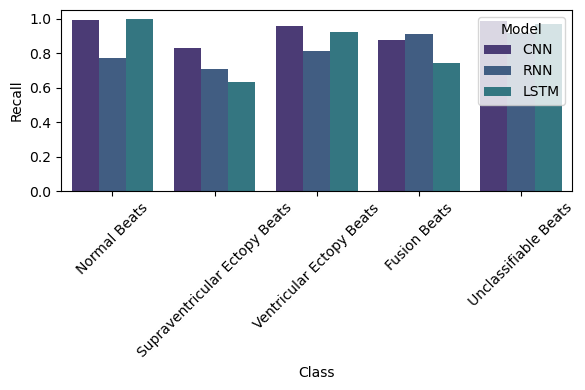

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette('viridis'))


# Extract recall scores
recall_scores_cnn = cnn_report_df.loc[0:4, 'recall']
recall_scores_rnn = rnn_report_df.loc[0:4, 'recall']
recall_scores_lstm = lstm_report_df.loc[0:4, 'recall']

# Create a DataFrame for recall scores
recall_scores_df = pd.DataFrame({
    'Class': class_names,
    'CNN': recall_scores_cnn.values,
    'RNN': recall_scores_rnn.values,
    'LSTM': recall_scores_lstm.values
})

# Melt the DataFrame for easier plotting
recall_scores_melted = pd.melt(recall_scores_df, id_vars='Class', var_name='Model', value_name='Recall')
#print(recall_scores_melted)

# Plot the recall scores comparison
plt.figure(figsize=(6, 4))
sns.barplot(x='Class', y='Recall', hue='Model', data=recall_scores_melted)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the figure it is possible to notice that both CNN and RNN model outperform the LSTM model in the three arrhythmias in terms of recall, especially for the "Supraventricular Ectopy Beats" and "Fusion Beats" classes.

#### Precision comparison between models

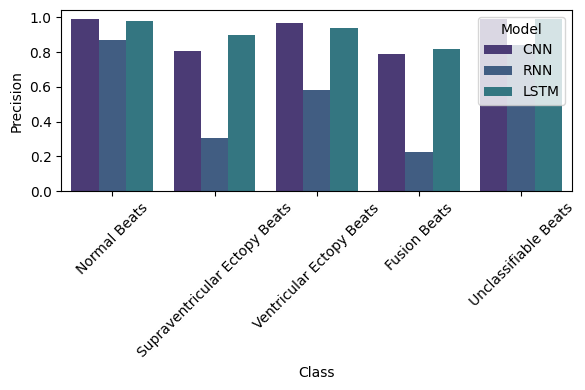

In [18]:
# Extract precision scores
precision_scores_cnn = cnn_report.loc[0:4, 'precision']
precision_scores_rnn = rnn_report.loc[0:4,'f1-score']
precision_scores_lstm = lstm_report_df.loc[0:4, 'precision']

precision_scores_df = pd.DataFrame({
    'Class': class_names,
    'CNN': precision_scores_cnn.values,
    'RNN': precision_scores_rnn.values,
    'LSTM': precision_scores_lstm.values
})

precision_scores_melted = pd.melt(precision_scores_df, id_vars='Class', var_name='Model', value_name='Precision')
#print(precision_scores_melted)

plt.figure(figsize=(6, 4))
sns.barplot(x='Class',y='Precision',hue='Model',data=precision_scores_melted)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the figure it is possible to see that the trained RNN, has the lowest precision in all the classes. Instead, in general the CNN and LSTM models have comparable precision across the diffferent classes, with the exception in the "Supraventricular Ectopy Beats" class

### F1-score comparison between models


In [16]:
# Extract F1 scores for each class (assuming class_names contains the names of your 5 classes)

f1_scores_cnn = cnn_report_df.loc[0:4, 'f1-score']
f1_scores_rnn = rnn_report_df.loc[0:4, 'f1-score']
f1_scores_lstm = lstm_report_df.loc[0:4, 'f1-score']

# Create a DataFrame for plotting
f1_scores_df = pd.DataFrame({
    'Class': class_names,
    'CNN': f1_scores_cnn.values,
    'RNN': f1_scores_rnn.values,
    'LSTM': f1_scores_lstm.values
})

# Melt DataFrame to long format for easier plotting
f1_scores_melted = pd.melt(f1_scores_df, id_vars='Class', var_name='Model', value_name='F1-Score')

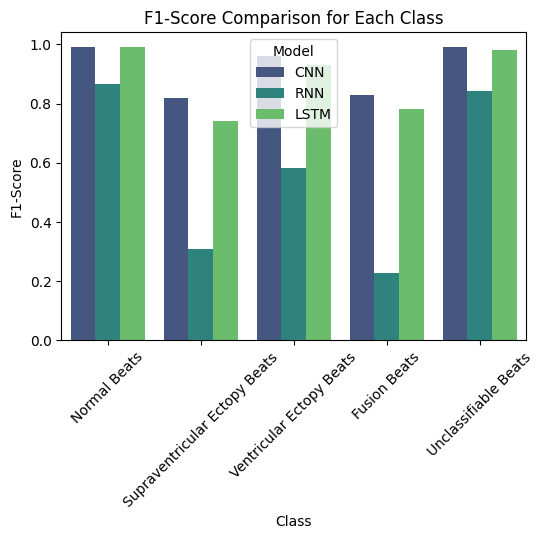

In [17]:
# Plot the F1-score comparison for each class
plt.figure(figsize=(6, 4))
sns.barplot(x='Class', y='F1-Score', hue='Model', data=f1_scores_melted, palette='viridis')
plt.title('F1-Score Comparison for Each Class')
plt.xticks(rotation=45)
plt.show()



From the obtained bar chart we can derive that:
- Normal Beats: Both CNN and LSTM models perform excellently, with F1-scores close to 1.0.
- Supraventricular Ectopy Beats: CNN slightly outperforms LSTM.
- Ventricular Ectopy Beats: CNN performs slightly better than LSTM.
- Fusion Beats: CNN performs slightly better than LSTM.
- Unclassifiable Beats: Both models perform equally well, with F1-scores near 1.0.
- RNN has the worst performance overall

Overall, CNN tend to perform better than the LSTM, it has a slight edge on Supraventricular Ectopy Beats. Both models perform well on Normal and Unclassifiable Beats, and less good for the Supraventricular Ectopy Beats and Fusion Beats.

#### Confusion matrices comparison

![](https://github.com/Alessio1599/single-ECG-classification/blob/main/final%20exam/comparison_confusion_matrices.png?raw=true)
![]()

<div>
<img src="https://github.com/Alessio1599/single-ECG-classification/blob/main/final%20exam/lstm_confusion_matrix.png?raw=true" width="600"/>
</div>

On the left is displayed the confusion matrix related to the CNN model, on the righ the confusion matrix of the RNN model and below the confusion matrix related to the "LSTM" model. Each matrix shows the true positive rates along the diagonal, indicating correct classifications, and off-diagonal values, indicating misclassifications.

From the figure it is possible to see that
- both CNN and RNN models have more misclassification for the "Supraventricular Ectopy Beats", 15%, which are misclassified as "Normal Beats"
- for the "Fusion Beats" class the RNN performs better than the CNN and "LSTM"
- LSTM achieves good results for the "Normal Beats" and "Unclassifiable Beats", but has the lowest reults for the "Supraventricular Ectopy Beats" and "FUsion Beats"

### Discussion
The results of this study suggest that a deep learning approach can classify a range of
distinct arrhythmias from single-lead ECGs with relatively high diagnostic performance.

The proposed CNN and RNN outperformed the "LSTM" in classifying two arrhythmias. Furthermore the CNN was able to ouperform the "LSTM" on all the three arrhythmias: "Supraventricular Ectopy Beats", "ventricular Ectopy Beats" and "Fusion Beats".


#### Future Work
Future work will compare the trained Deep Learning models with the gold standard cardiologist consensus comittee, as instance fixing the specificity and looking at the sensitivity in the DNN models and in the average cardiologist, as performed in other studies.

Future studies will use a dataset with large number of classes, and will also consider that classes can be non-exclusive, for certain signals it is possible to have multiple conditions simultaneously.

Future work will improve the RNN model, looking at different combination of the hyperparmeters and layers in the model, also using the workflow that I defined for the hyperparameter tuning.


To improve the performance of the models Data Augmentation could be used to increase the samples in the minority classes.

<a name='6'></a>
## References
1. [ECG Heartbeat Categorization Dataset, Kaggle](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
2.[sweeps wandb](https://docs.wandb.ai/tutorials/sweeps)
3. Cardiologist-level arrhythmia detection and
classification in ambulatory electrocardiograms
using a deep neural network, Nature medicine, 2019, Awni Hannun, Pranav Rajpurkar



## Other references
- [How to use/download kaggle datasets in Google Colab, Kaggle](https://www.kaggle.com/discussions/general/371462#2060661)
- [How to (intermittently) skip certain cells when running IPython notebook?](https://stackoverflow.com/questions/19309287/how-to-intermittently-skip-certain-cells-when-running-ipython-notebook#:~:text=To%20skip%20a%20cell%2C%20simply,top%20line%20of%20the%20cell.)
- [Limitations of receiver operating characteristic curve on imbalanced data: Assist device mortality risk scores](https://pmc.ncbi.nlm.nih.gov/articles/PMC8800945/#:~:text=However%2C%20when%20the%20data%20is,prediction%20of%20the%20minority%20class.)